# Data Set Processing

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
RPPA_file = "datasets/CCLE_RPPA_20181003.csv"
ab_gene_match_file = "datasets/For_AbGeneMatch_CCLE_RPPA_Ab_info_20181226.csv"
gene_dependency_file = "datasets/CRISPR_gene_dependency.csv"
CCLE_depMap_file = "datasets/For_cellLineIDmatch_Cell_lines_annotations_20181226.txt"
features_file = 'datasets/cancer_features.csv' 
target_file = 'datasets/cancer_target.csv'

In [3]:
RPPA = pd.read_csv(RPPA_file)
RPPA.describe()

,14-3-3_beta,14-3-3_epsilon_Caution,14-3-3_zeta,4E-BP1,4E-BP1_pS65,4E-BP1_pT37_T46,4E-BP1_pT70,53BP1,A-Raf_pS299_Caution,ACC_pS79,...,Tuberin_pT1462,VAV1_Caution,VEGFR2,VHL_Caution,XBP1_Caution,XRCC1_Caution,YAP_Caution,YAP_pS127_Caution,YB-1,YB-1_pS102
count,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,...,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,0.020628,0.016819,0.045814,0.016372,0.047341,0.007481,0.016725,-0.037889,0.051844,0.025452,...,0.049834,0.956573,-0.157588,0.172303,0.011615,0.002029,-0.090400,-0.396433,0.029549,0.001457
std,0.204898,0.195318,0.434349,0.557095,0.568339,0.684936,0.326404,0.684916,0.350719,0.695605,...,0.346816,2.205048,1.209675,1.828519,0.278189,0.290509,0.671671,1.520798,0.300404,0.424010
min,-0.535620,-0.460877,-1.740304,-1.629459,-1.577739,-2.042435,-1.112947,-3.971552,-0.786694,-2.260155,...,-0.626090,-1.482742,-4.416189,-2.859577,-0.732519,-1.822826,-1.970780,-3.613979,-0.797192,-1.463981
25%,-0.111841,-0.110970,-0.222334,-0.368105,-0.345423,-0.482774,-0.184319,-0.412579,-0.182039,-0.442814,...,-0.186082,-0.367048,-1.020217,-1.399193,-0.174156,-0.168304,-0.558026,-1.656151,-0.160149,-0.246714
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.132669,0.119803,0.293232,0.396490,0.401769,0.455078,0.192844,0.383596,0.222944,0.463639,...,0.210101,0.842461,0.731983,1.485550,0.184386,0.181120,0.382379,0.703453,0.171506,0.245077
max,1.201617,2.260478,1.671737,1.817040,2.288786,2.401416,1.563114,2.004192,1.986489,2.937330,...,1.837025,7.230210,2.861897,6.120173,1.401679,0.958144,3.184941,3.832591,1.471733,1.961908


In [4]:
ab_genes_match = pd.read_csv(ab_gene_match_file) 
ab_genes_match.head()

,Antibody_Name,Target_Genes,Validation_Status,Company,Catalog_Number
0,14-3-3_beta,YWHAB,Validated,Santa Cruz,sc-628
1,14-3-3_epsilon_Caution,YWHAE,Caution,Santa Cruz,sc-23957
2,14-3-3_zeta,YWHAZ,Validated,Santa Cruz,sc-1019
3,4E-BP1,EIF4EBP1,Validated,CST,9452
4,4E-BP1_pS65,EIF4EBP1,Validated,CST,9456


In [5]:
validated_ab_genes_match = ab_genes_match[ab_genes_match.Validation_Status == "Validated"].sort_values(by=["Target_Genes","Antibody_Name"])
validated_ab_genes_match

,Antibody_Name,Target_Genes,Validation_Status,Company,Catalog_Number
9,ACC_pS79,ACACA ACACB,Validated,CST,3661
13,ADAR1,ADAR,Validated,Abcam,ab88574
14,Akt,AKT1 AKT2 AKT3,Validated,CST,4691
15,Akt_pS473,AKT1 AKT2 AKT3,Validated,CST,9271
16,Akt_pT308,AKT1 AKT2 AKT3,Validated,CST,2965
...,...,...,...,...,...
197,TAZ,WWTR1,Validated,CST,2149
212,YB-1,YBX1,Validated,Novus Biologicals,17250002
213,YB-1_pS102,YBX1,Validated,CST,2900
0,14-3-3_beta,YWHAB,Validated,Santa Cruz,sc-628


In [6]:
validated_ab_genes_match.Target_Genes = validated_ab_genes_match.Target_Genes.str.extract(r'^\b(\w+)',expand = True)

In [7]:
validated_ab_genes_match_dedup = validated_ab_genes_match.drop_duplicates(subset=['Target_Genes'], keep='first')
validated_ab_genes_match_dedup

,Antibody_Name,Target_Genes,Validation_Status,Company,Catalog_Number
9,ACC_pS79,ACACA,Validated,CST,3661
13,ADAR1,ADAR,Validated,Abcam,ab88574
14,Akt,AKT1,Validated,CST,4691
163,PRAS40_pT246,AKT1S1,Validated,Life Technologies,441100G
20,Annexin 1,ANXA1,Validated,BD Biosciences,610066
...,...,...,...,...,...
161,Porin,VDAC1,Validated,NaN,NaN
197,TAZ,WWTR1,Validated,CST,2149
212,YB-1,YBX1,Validated,Novus Biologicals,17250002
0,14-3-3_beta,YWHAB,Validated,Santa Cruz,sc-628


In [8]:
antibody_targetgenes_mapping = dict(zip(validated_ab_genes_match_dedup["Antibody_Name"], validated_ab_genes_match_dedup["Target_Genes"]))
antibody_targetgenes_mapping

{'ACC_pS79': 'ACACA',
 'ADAR1': 'ADAR',
 'Akt': 'AKT1',
 'PRAS40_pT246': 'AKT1S1',
 'Annexin 1': 'ANXA1',
 'Annexin_VII': 'ANXA7',
 'AR': 'AR',
 'ASNS': 'ASNS',
 'ATM': 'ATM',
 'Bad_pS112': 'BAD',
 'Bap1 c-4': 'BAP1',
 'Bax': 'BAX',
 'Bcl-2': 'BCL2',
 'Bcl-xL': 'BCL2L1',
 'Bim(CST2933)': 'BCL2L11',
 'B-Raf_pS445': 'BRAF',
 'TIGAR': 'C12orf5',
 'Caveolin-1': 'CAV1',
 'Cyclin_B1': 'CCNB1',
 'Cyclin_D1': 'CCND1',
 'Cyclin_E1': 'CCNE1',
 'E-Cadherin': 'CDH1',
 'N-Cadherin': 'CDH2',
 'CDK1': 'CDK1',
 'p21': 'CDKN1A',
 'p27': 'CDKN1B',
 'Chk2': 'CHEK2',
 'Claudin-7': 'CLDN7',
 'Collagen_VI': 'COL6A1',
 'alpha-Catenin': 'CTNNB1',
 'Dvl3': 'DVL3',
 'eEF2K': 'EEF2K',
 'EGFR': 'EGFR',
 'eIF4E': 'EIF4E',
 '4E-BP1': 'EIF4EBP1',
 'HER2': 'ERBB2',
 'HER3': 'ERBB3',
 'MIG-6': 'ERRFI1',
 'ER-alpha': 'ESR1',
 'ETS-1': 'ETS1',
 'FASN': 'FASN',
 'Fibronectin': 'FN1',
 'FoxM1': 'FOXM1',
 'G6PD': 'G6PD',
 'Gab2': 'GAB2',
 'GATA3': 'GATA3',
 'GSK3-alpha-beta': 'GSK3A',
 'IGFBP2': 'IGFBP2',
 'INPP4B': 'INPP4

In [9]:
RPPA_target_genes = RPPA.rename(columns=antibody_targetgenes_mapping)
RPPA_target_genes

,Cell_Lines,YWHAB,14-3-3_epsilon_Caution,YWHAZ,EIF4EBP1,4E-BP1_pS65,4E-BP1_pT37_T46,4E-BP1_pT70,TP53BP1,A-Raf_pS299_Caution,...,Tuberin_pT1462,VAV1_Caution,KDR,VHL_Caution,XBP1_Caution,XRCC1_Caution,YAP_Caution,YAP_pS127_Caution,YBX1,YB-1_pS102
0,DMS53_LUNG,-0.104888,0.060414,0.309068,-0.075506,0.230359,0.198304,-0.030541,0.455889,0.090484,...,-0.099433,-0.486715,-1.147858,0.133876,-0.075812,-0.144388,-1.090303,-2.109324,0.178104,0.246541
1,SW1116_LARGE_INTESTINE,0.358504,-0.180291,-0.041237,-0.286629,-0.877406,-1.026948,-0.462761,-0.011197,0.605330,...,-0.109777,0.349330,0.770148,0.984297,-0.168138,-0.004905,0.189294,-0.283593,0.255972,-0.121134
2,NCIH1694_LUNG,0.028738,0.071902,-0.094847,0.285069,1.321551,0.620703,-0.439484,0.195007,0.036221,...,0.154344,-0.478189,-1.185530,1.273013,-0.240413,0.476633,-1.367465,-2.525695,-0.137880,-0.451282
3,P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.120039,-0.066802,-0.128007,-0.552081,-0.292428,-1.415935,-0.138858,-0.066122,-0.346564,...,0.040106,5.923830,-3.893832,-2.499188,0.632758,0.025639,-1.189180,-3.056863,0.025997,-0.465205
4,HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.268997,-0.060281,-0.137881,-0.398729,-0.095622,-0.533905,0.054245,-0.573022,-0.162968,...,-0.466919,5.475880,-0.561973,-0.500953,-0.261494,0.358679,-0.951686,-3.247388,-0.151424,-0.145426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,UO31_KIDNEY,0.043231,0.093158,0.105461,0.011264,-0.264052,-0.079559,-0.000355,-0.308669,-0.025941,...,-0.109095,0.137608,0.618270,-0.541645,0.263695,-0.092934,0.433857,0.327542,0.108921,-0.197684
895,SF268_CENTRAL_NERVOUS_SYSTEM,-0.034597,0.065964,-0.329024,-0.540973,0.492108,0.137051,-0.003109,-0.276884,-0.390067,...,-0.339392,-0.054790,-0.271650,-1.735560,-0.397684,-0.166362,2.550478,3.225039,0.136907,0.426637
896,SF539_CENTRAL_NERVOUS_SYSTEM,-0.250998,0.420490,-0.334213,-0.156368,-0.219208,-0.187704,0.240884,0.352163,0.052992,...,0.094319,0.346651,-0.367292,-1.851276,0.069242,0.165163,-0.174660,-0.811089,0.067923,0.237027
897,SNB75_CENTRAL_NERVOUS_SYSTEM,-0.139833,0.194831,-0.135708,-0.434248,0.208941,-0.071338,0.145042,-0.457499,0.032008,...,0.159241,-0.140213,0.436948,-1.476417,-0.390487,-0.163100,0.407310,0.390911,-0.034470,0.153921


In [10]:
gene_dependency = pd.read_csv(gene_dependency_file)
gene_dependency

,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,VSIR (64115),VSNL1 (7447),VSTM1 (284415),VSTM2A (222008),VSTM2B (342865),VSTM2L (128434),VSTM4 (196740),VSTM5 (387804),VSX1 (30813),VSX2 (338917)
0,ACH-000001,0.094568,0.012519,0.027460,0.025962,0.073412,0.027340,0.020199,0.284733,0.022084,...,0.001292,0.024492,0.084157,0.012462,0.335857,0.020174,0.018738,0.010192,0.052139,0.008297
1,ACH-000004,0.012676,0.049011,0.075933,0.033215,0.013176,0.097497,0.005015,0.153166,0.007358,...,0.008273,0.011980,0.014436,0.025303,0.007004,0.243606,0.022201,0.050359,0.066077,0.015825
2,ACH-000005,0.053957,0.027968,0.010139,0.005448,0.018599,0.081636,0.005457,0.159904,0.050884,...,0.023400,0.005475,0.012692,0.020985,0.038026,0.024892,0.168283,0.064798,0.030023,0.051794
3,ACH-000007,0.026704,0.083588,0.008853,0.011299,0.027288,0.028349,0.032573,0.166503,0.047045,...,0.014673,0.073007,0.008660,0.037720,0.127976,0.006256,0.014220,0.108180,0.016265,0.004456
4,ACH-000009,0.059383,0.051826,0.015370,0.011721,0.030062,0.078373,0.042128,0.184783,0.032335,...,0.007147,0.053239,0.045631,0.024059,0.092080,0.022770,0.009242,0.064912,0.004815,0.021191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,ACH-000319,0.026292,0.088123,0.017270,0.014591,0.076235,0.044388,0.012286,0.131479,0.007508,...,0.030193,0.026425,0.010602,0.051562,0.030349,0.006083,0.028168,0.168244,0.035197,0.013529
195,ACH-000320,0.017140,0.037649,0.138543,0.015138,0.061140,0.143692,0.016970,0.256992,0.013758,...,0.020917,0.062133,0.022408,0.028914,0.109533,0.029447,0.004894,0.024019,0.017836,0.010251
196,ACH-000322,0.022651,0.055122,0.036306,0.021726,0.377140,0.017162,0.089657,0.065863,0.365338,...,0.020951,0.060709,0.017047,0.022073,0.011476,0.046791,0.047908,0.011999,0.138596,0.032564
197,ACH-000323,0.037762,0.047568,0.021621,0.002864,0.154532,0.074798,0.072291,0.087464,0.043345,...,0.030311,0.102764,0.009064,0.008808,0.057539,0.012210,0.043316,0.036902,0.006637,0.038722


In [11]:
CCLE_depMap = pd.read_csv(CCLE_depMap_file, sep="\t")

In [12]:
CCLE_depMap_clean = CCLE_depMap.dropna(subset=["depMapID"])

In [13]:
CCLE_depMap_mapping = dict(zip(CCLE_depMap_clean["depMapID"], CCLE_depMap_clean["CCLE_ID"]))
CCLE_depMap_mapping

{'ACH-000698': 'DMS53_LUNG',
 'ACH-000489': 'SW1116_LARGE_INTESTINE',
 'ACH-000431': 'NCIH1694_LUNG',
 'ACH-000707': 'P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'ACH-000509': 'HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'ACH-000522': 'UMUC3_URINARY_TRACT',
 'ACH-000613': 'HOS_BONE',
 'ACH-000829': 'HUNS1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'ACH-000557': 'AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'ACH-000614': 'RVH421_SKIN',
 'ACH-000523': 'NCIH1184_LUNG',
 'ACH-000691': 'HCC2157_BREAST',
 'ACH-000424': 'TC71_BONE',
 'ACH-000610': 'NCIH2227_LUNG',
 'ACH-001039': 'COLO205_LARGE_INTESTINE',
 'ACH-000420': 'SNU449_LIVER',
 'ACH-000648': 'NCIH28_PLEURA',
 'ACH-000091': 'OV56_OVARY',
 'ACH-000584': 'JHOS4_OVARY',
 'ACH-000865': 'KYSE450_OESOPHAGUS',
 'ACH-000701': 'RMUGS_OVARY',
 'ACH-000293': 'KLE_ENDOMETRIUM',
 'ACH-000043': 'HS895T_FIBROBLAST',
 'ACH-000595': 'LN229_CENTRAL_NERVOUS_SYSTEM',
 'ACH-000770': 'P31FUJ_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'ACH-000505': 'RKN_SOFT_TISSUE',

In [14]:
gene_dependency_columns = {i: i.split()[0] for i in gene_dependency.columns}
gene_dependency_columns["DepMap_ID"] = "Cell_Lines"
gene_dependency_columns

{'DepMap_ID': 'Cell_Lines',
 'A1BG (1)': 'A1BG',
 'A1CF (29974)': 'A1CF',
 'A2M (2)': 'A2M',
 'A2ML1 (144568)': 'A2ML1',
 'A3GALT2 (127550)': 'A3GALT2',
 'A4GALT (53947)': 'A4GALT',
 'A4GNT (51146)': 'A4GNT',
 'AAAS (8086)': 'AAAS',
 'AACS (65985)': 'AACS',
 'AADAC (13)': 'AADAC',
 'AADACL2 (344752)': 'AADACL2',
 'AADACL3 (126767)': 'AADACL3',
 'AADACL4 (343066)': 'AADACL4',
 'AADAT (51166)': 'AADAT',
 'AAGAB (79719)': 'AAGAB',
 'AAK1 (22848)': 'AAK1',
 'AAMDC (28971)': 'AAMDC',
 'AAMP (14)': 'AAMP',
 'AANAT (15)': 'AANAT',
 'AAR2 (25980)': 'AAR2',
 'AARD (441376)': 'AARD',
 'AARS1 (16)': 'AARS1',
 'AARS2 (57505)': 'AARS2',
 'AARSD1 (80755)': 'AARSD1',
 'AASDH (132949)': 'AASDH',
 'AASDHPPT (60496)': 'AASDHPPT',
 'AASS (10157)': 'AASS',
 'AATF (26574)': 'AATF',
 'AATK (9625)': 'AATK',
 'ABAT (18)': 'ABAT',
 'ABCA1 (19)': 'ABCA1',
 'ABCA10 (10349)': 'ABCA10',
 'ABCA12 (26154)': 'ABCA12',
 'ABCA13 (154664)': 'ABCA13',
 'ABCA2 (20)': 'ABCA2',
 'ABCA3 (21)': 'ABCA3',
 'ABCA4 (24)': 'ABCA4'

In [15]:
gene_dependency_renamed = gene_dependency.rename(columns=gene_dependency_columns)
gene_dependency_renamed["Cell_Lines"] = gene_dependency_renamed["Cell_Lines"].map(CCLE_depMap_mapping)
gene_dependency_renamed = gene_dependency_renamed.dropna(subset=["Cell_Lines"])
gene_dependency_renamed.sort_index()

,Cell_Lines,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,VSIR,VSNL1,VSTM1,VSTM2A,VSTM2B,VSTM2L,VSTM4,VSTM5,VSX1,VSX2
0,NIHOVCAR3_OVARY,0.094568,0.012519,0.027460,0.025962,0.073412,0.027340,0.020199,0.284733,0.022084,...,0.001292,0.024492,0.084157,0.012462,0.335857,0.020174,0.018738,0.010192,0.052139,0.008297
1,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.012676,0.049011,0.075933,0.033215,0.013176,0.097497,0.005015,0.153166,0.007358,...,0.008273,0.011980,0.014436,0.025303,0.007004,0.243606,0.022201,0.050359,0.066077,0.015825
2,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.053957,0.027968,0.010139,0.005448,0.018599,0.081636,0.005457,0.159904,0.050884,...,0.023400,0.005475,0.012692,0.020985,0.038026,0.024892,0.168283,0.064798,0.030023,0.051794
3,LS513_LARGE_INTESTINE,0.026704,0.083588,0.008853,0.011299,0.027288,0.028349,0.032573,0.166503,0.047045,...,0.014673,0.073007,0.008660,0.037720,0.127976,0.006256,0.014220,0.108180,0.016265,0.004456
4,C2BBE1_LARGE_INTESTINE,0.059383,0.051826,0.015370,0.011721,0.030062,0.078373,0.042128,0.184783,0.032335,...,0.007147,0.053239,0.045631,0.024059,0.092080,0.022770,0.009242,0.064912,0.004815,0.021191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,MPP89_PLEURA,0.026292,0.088123,0.017270,0.014591,0.076235,0.044388,0.012286,0.131479,0.007508,...,0.030193,0.026425,0.010602,0.051562,0.030349,0.006083,0.028168,0.168244,0.035197,0.013529
195,PSN1_PANCREAS,0.017140,0.037649,0.138543,0.015138,0.061140,0.143692,0.016970,0.256992,0.013758,...,0.020917,0.062133,0.022408,0.028914,0.109533,0.029447,0.004894,0.024019,0.017836,0.010251
196,HT144_SKIN,0.022651,0.055122,0.036306,0.021726,0.377140,0.017162,0.089657,0.065863,0.365338,...,0.020951,0.060709,0.017047,0.022073,0.011476,0.046791,0.047908,0.011999,0.138596,0.032564
197,42MGBA_CENTRAL_NERVOUS_SYSTEM,0.037762,0.047568,0.021621,0.002864,0.154532,0.074798,0.072291,0.087464,0.043345,...,0.030311,0.102764,0.009064,0.008808,0.057539,0.012210,0.043316,0.036902,0.006637,0.038722


In [16]:
common_columns = gene_dependency_renamed.columns.intersection(RPPA_target_genes.columns)
common_columns

Index(['Cell_Lines', 'ACACA', 'ADAR', 'AKT1', 'AKT1S1', 'ANXA1', 'ANXA7', 'AR',
       'ASNS', 'ATM',
       ...
       'STAT3', 'STAT5A', 'STMN1', 'SYK', 'TFRC', 'TGM2', 'TP53BP1', 'TSC2',
       'TTF1', 'VDAC1'],
      dtype='object', length=108)

In [17]:
common_Cell_Lines = pd.merge(RPPA_target_genes, gene_dependency_renamed, how='inner', on=['Cell_Lines'])["Cell_Lines"]
common_Cell_Lines

0                              KLE_ENDOMETRIUM
1                           PATU8988S_PANCREAS
2                       OUMS23_LARGE_INTESTINE
3                              SW1990_PANCREAS
4                             RERFGC1B_STOMACH
                        ...                   
173    L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
174                     SIMA_AUTONOMIC_GANGLIA
175                       CL11_LARGE_INTESTINE
176                              CAL120_BREAST
177               SF539_CENTRAL_NERVOUS_SYSTEM
Name: Cell_Lines, Length: 178, dtype: object

In [18]:
gene_dependency_renamed[gene_dependency_renamed['Cell_Lines'] == 'PATU8988S_PANCREAS'][common_columns]

,Cell_Lines,ACACA,ADAR,AKT1,AKT1S1,ANXA1,ANXA7,AR,ASNS,ATM,...,STAT3,STAT5A,STMN1,SYK,TFRC,TGM2,TP53BP1,TSC2,TTF1,VDAC1
14,PATU8988S_PANCREAS,0.967262,0.750864,0.374418,0.045866,0.003127,0.041423,0.015572,0.905071,0.008182,...,0.047731,0.124919,0.017262,0.064282,0.892578,0.029166,0.042842,0.095331,0.52897,0.965447


In [19]:
RPPA_target_genes[RPPA_target_genes['Cell_Lines'] == 'PATU8988S_PANCREAS'][common_columns]

,Cell_Lines,ACACA,ADAR,AKT1,AKT1S1,ANXA1,ANXA7,AR,ASNS,ATM,...,STAT3,STAT5A,STMN1,SYK,TFRC,TGM2,TP53BP1,TSC2,TTF1,VDAC1
24,PATU8988S_PANCREAS,0.317384,-0.278946,-0.544626,-0.376471,-0.407101,0.210352,0.104777,-0.549061,0.570903,...,-0.071678,-0.229965,-0.046128,2.95858,0.64679,-0.337351,-0.520172,-0.272228,-0.204088,-0.568497


In [20]:
cancer_gene_dataset = gene_dependency_renamed[gene_dependency_renamed['Cell_Lines'].isin(common_Cell_Lines.tolist())][common_columns]

In [21]:
cancer_target = cancer_gene_dataset.fillna(0).set_index('Cell_Lines').sort_index()
cancer_target

,ACACA,ADAR,AKT1,AKT1S1,ANXA1,ANXA7,AR,ASNS,ATM,BAD,...,STAT3,STAT5A,STMN1,SYK,TFRC,TGM2,TP53BP1,TSC2,TTF1,VDAC1
Cell_Lines,,,,,,,,,,,,,,,,,,,,,
253J_URINARY_TRACT,0.291093,0.861309,0.087815,0.016422,0.002513,0.036449,0.008699,0.869700,0.001998,0.063739,...,0.037990,0.545620,0.064375,0.018900,0.806288,0.013950,0.000344,0.062252,0.511879,0.842038
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.453494,0.692183,0.267013,0.016146,0.030225,0.134950,0.018608,0.793303,0.012925,0.051808,...,0.106812,0.144882,0.044903,0.024999,0.236526,0.002458,0.028104,0.025255,0.617330,0.862326
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.733079,0.015357,0.065456,0.007994,0.091261,0.015945,0.011866,0.309521,0.157976,0.011430,...,0.010876,0.568588,0.034588,0.425239,0.989458,0.001678,0.046296,0.018030,0.301100,0.038885
8MGBA_CENTRAL_NERVOUS_SYSTEM,0.324004,0.816500,0.046975,0.027912,0.029138,0.097739,0.023289,0.764097,0.070163,0.224208,...,0.047200,0.561390,0.019719,0.013328,0.294601,0.006528,0.020899,0.043964,0.801040,0.808662
A375_SKIN,0.442446,0.855541,0.093585,0.015543,0.023308,0.058055,0.015156,0.781848,0.051633,0.265799,...,0.029655,0.274395,0.146340,0.039810,0.971959,0.012099,0.076451,0.582738,0.447034,0.965520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U251MG_CENTRAL_NERVOUS_SYSTEM,0.799759,0.758230,0.127058,0.030227,0.008224,0.091288,0.022970,0.783167,0.133741,0.053196,...,0.212723,0.303616,0.086941,0.007534,0.605412,0.011307,0.101230,0.001294,0.629889,0.934348
U87MG_CENTRAL_NERVOUS_SYSTEM,0.331833,0.063844,0.150991,0.037618,0.029293,0.010191,0.152989,0.317410,0.019436,0.143155,...,0.040547,0.658088,0.005591,0.103481,0.514781,0.005342,0.018758,0.103696,0.725967,0.846281
VCAP_PROSTATE,0.109632,0.713721,0.117967,0.017846,0.038414,0.187279,0.117247,0.610196,0.063139,0.258442,...,0.103622,0.483425,0.117384,0.075563,0.579833,0.022381,0.082799,0.195422,0.297515,0.890767


In [22]:
cancer_features = RPPA_target_genes[RPPA_target_genes['Cell_Lines'] \
                        .isin(common_Cell_Lines.tolist())][common_columns].fillna(0).set_index('Cell_Lines').sort_index()
cancer_features

,ACACA,ADAR,AKT1,AKT1S1,ANXA1,ANXA7,AR,ASNS,ATM,BAD,...,STAT3,STAT5A,STMN1,SYK,TFRC,TGM2,TP53BP1,TSC2,TTF1,VDAC1
Cell_Lines,,,,,,,,,,,,,,,,,,,,,
253J_URINARY_TRACT,-0.118793,-0.003122,0.386922,-0.132071,3.457757,-0.213027,-0.000389,0.705926,-0.573477,-0.039916,...,-0.087225,-1.009143,-0.160196,-1.648796,0.416935,1.141666,0.757307,-0.068059,1.317874,0.257866
42MGBA_CENTRAL_NERVOUS_SYSTEM,-0.356395,-0.456026,0.498819,0.159492,-0.094183,0.059905,0.492375,0.254258,1.347601,0.034971,...,0.155265,0.344516,0.468471,-1.736337,-0.323282,-0.107640,-0.763783,0.270572,-0.098186,-1.005579
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.315275,-0.260211,0.301291,0.251107,-1.552633,-0.276847,1.524470,0.163773,0.724278,-0.207355,...,-0.511560,2.094885,0.982444,2.197400,-1.018094,-0.399346,0.081912,0.252279,0.213935,-0.052135
8MGBA_CENTRAL_NERVOUS_SYSTEM,-0.027029,-0.145514,-0.634421,-0.312058,-0.391638,-0.034738,-0.048559,1.770983,-0.139403,0.261715,...,-0.015707,0.706352,0.145614,-0.856897,-0.354509,0.629384,-0.334474,0.528070,-0.415322,-1.854639
A375_SKIN,0.326154,0.110948,0.949963,-0.362769,0.854661,-0.191524,0.117271,0.721298,1.317808,0.007346,...,0.063000,1.284845,-0.133421,-1.263004,-1.888393,0.174917,-0.637714,0.593283,-0.414452,-1.508149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U251MG_CENTRAL_NERVOUS_SYSTEM,0.695949,-0.125773,0.571097,-0.037803,1.325704,-0.113516,1.247167,-0.422855,0.912138,0.233867,...,0.299817,0.149449,0.018078,-1.264099,-0.534039,-0.234773,1.417070,0.534327,-0.283009,0.022130
U87MG_CENTRAL_NERVOUS_SYSTEM,0.062295,-0.391611,0.337607,0.483450,1.749957,-0.183323,0.771114,1.892671,-0.529678,0.453397,...,-0.333216,-0.235068,-0.527045,-2.340456,0.660340,1.511420,0.379008,0.285863,0.868880,0.423769
VCAP_PROSTATE,2.937330,0.566385,0.002488,0.163532,-0.524336,0.536815,5.661684,-0.694395,0.520303,-0.032066,...,-0.442922,-0.009907,-0.105369,1.200237,-0.356352,-0.137566,0.484006,-0.086070,-0.283266,0.149612


In [23]:
cancer_features.to_csv(features_file, index=False)

In [24]:
cancer_target.to_csv(target_file, index=False)

# Model Training

## Linear Regression

In [25]:
linear_regression = {}
for col in cancer_features:
    linear_regression[col] = {}
    cancer_features_np = cancer_features.loc[:, col].to_numpy().reshape(-1,1)
    cancer_target_np = cancer_target.loc[:, col].to_numpy()
    
    # Splitting DataSet to Training Set 70% and Test Set 30%
    X_train, X_test, y_train, y_test = train_test_split(cancer_features_np, cancer_target_np, train_size = 0.7, test_size=0.3, random_state = 0)

    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # 10 Fold 
    cv = KFold(n_splits=5, random_state=13, shuffle=True) 

    # Linear Regression Pipeline
    linreg_pipeline = Pipeline([('linreg', LinearRegression())])
    linreg_pipeline.set_params(linreg__n_jobs=-1)

    #Training Model on 10 Fold Training Dataset
    for train_index , test_index in cv.split(X_train):
        X_train_kf , X_test_kf = pd.DataFrame(X_train).iloc[train_index,:], pd.DataFrame(X_train).iloc[test_index,:]
        y_train_kf , y_test_kf = pd.DataFrame(y_train).iloc[train_index,:], pd.DataFrame(y_train).iloc[test_index,:]

        linreg_pipeline.fit(X_train_kf,y_train_kf)
        
    
    R2_train = r2_score(y_train, linreg_pipeline.predict(X_train))
    RMSE_train = np.sqrt(mean_squared_error(y_train, linreg_pipeline.predict(X_train)))
    print('R-squared score (train): {:.3f}'.format(R2_train))
    print('RMSE score (train): {:.3f}'.format(RMSE_train))

    R2_test = r2_score(y_test, linreg_pipeline.predict(X_test))
    RMSE_test = np.sqrt(mean_squared_error(y_test, linreg_pipeline.predict(X_test)))
    print('R-squared score (test): {:.3f}'.format(R2_test))
    print('RMSE score (test): {:.3f}'.format(RMSE_test))

    
    linear_regression[col]['R2_train']=R2_train    
    linear_regression[col]['RMSE_train']=RMSE_train
    linear_regression[col]['R2_test']=R2_test    
    linear_regression[col]['RMSE_test']=RMSE_test

R-squared score (train): 0.041
RMSE score (train): 0.292
R-squared score (test): -0.006
RMSE score (test): 0.273
R-squared score (train): 0.041
RMSE score (train): 0.317
R-squared score (test): 0.115
RMSE score (test): 0.326
R-squared score (train): -0.000
RMSE score (train): 0.145
R-squared score (test): -0.006
RMSE score (test): 0.116
R-squared score (train): 0.011
RMSE score (train): 0.033
R-squared score (test): -0.012
RMSE score (test): 0.033
R-squared score (train): 0.015
RMSE score (train): 0.042
R-squared score (test): -0.133
RMSE score (test): 0.035
R-squared score (train): -0.009
RMSE score (train): 0.079
R-squared score (test): -0.037
RMSE score (test): 0.071
R-squared score (train): 0.117
RMSE score (train): 0.024
R-squared score (test): -0.063
RMSE score (test): 0.035
R-squared score (train): 0.017
RMSE score (train): 0.279
R-squared score (test): -0.024
RMSE score (test): 0.266
R-squared score (train): 0.001
RMSE score (train): 0.086
R-squared score (test): -0.107
RMSE sc

R-squared score (train): 0.008
RMSE score (train): 0.303
R-squared score (test): -0.090
RMSE score (test): 0.255
R-squared score (train): -0.005
RMSE score (train): 0.000
R-squared score (test): -0.024
RMSE score (test): 0.001
R-squared score (train): 0.016
RMSE score (train): 0.215
R-squared score (test): -0.006
RMSE score (test): 0.240
R-squared score (train): -0.003
RMSE score (train): 0.166
R-squared score (test): -0.020
RMSE score (test): 0.158
R-squared score (train): 0.022
RMSE score (train): 0.297
R-squared score (test): -0.049
RMSE score (test): 0.256
R-squared score (train): 0.002
RMSE score (train): 0.018
R-squared score (test): -0.044
RMSE score (test): 0.020
R-squared score (train): 0.057
RMSE score (train): 0.204
R-squared score (test): -0.506
RMSE score (test): 0.161
R-squared score (train): -0.011
RMSE score (train): 0.034
R-squared score (test): -0.022
RMSE score (test): 0.021
R-squared score (train): 0.001
RMSE score (train): 0.056
R-squared score (test): 0.016
RMSE s

In [26]:
linear_regression

{'ACACA': {'R2_train': 0.041398884311693696,
  'RMSE_train': 0.2915383420982325,
  'R2_test': -0.006106481980104883,
  'RMSE_test': 0.2727924719769195},
 'ADAR': {'R2_train': 0.040799821048405405,
  'RMSE_train': 0.31744398753103287,
  'R2_test': 0.11467405192857216,
  'RMSE_test': 0.3258542788541431},
 'AKT1': {'R2_train': -0.0003729486172596719,
  'RMSE_train': 0.14537973644385976,
  'R2_test': -0.006219331960749752,
  'RMSE_test': 0.11608933887030294},
 'AKT1S1': {'R2_train': 0.010521135807993853,
  'RMSE_train': 0.03345986816264331,
  'R2_test': -0.011609953434747133,
  'RMSE_test': 0.03313646433892076},
 'ANXA1': {'R2_train': 0.015037361989322151,
  'RMSE_train': 0.0416115872892342,
  'R2_test': -0.13309989625304297,
  'RMSE_test': 0.03512686259094333},
 'ANXA7': {'R2_train': -0.009265819481968585,
  'RMSE_train': 0.07891564954756752,
  'R2_test': -0.036754141933345474,
  'RMSE_test': 0.07064268885307337},
 'AR': {'R2_train': 0.11701703451181844,
  'RMSE_train': 0.0236062278485479

## Random Forest

In [27]:
random_forest = {}
for col in cancer_features:
    random_forest[col] = {}
    cancer_features_np = cancer_features.loc[:, col].to_numpy().reshape(-1,1)
    cancer_target_np = cancer_target.loc[:, col].to_numpy()
    
    # Splitting DataSet to Training Set 70% and Test Set 30%
    X_train, X_test, y_train, y_test = train_test_split(cancer_features_np, cancer_target_np, train_size = 0.7, test_size=0.3, random_state = 0)

    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # 10 Fold 
    cv = KFold(n_splits=10, random_state=13, shuffle=True)

    # Random Forest Pipeline
    randomforest_pipeline = Pipeline([('randforestreg', RandomForestRegressor())])
    randomforest_pipeline.set_params(randforestreg__n_jobs=-1, randforestreg__random_state=26)

    # Training model on 10 fold Training dataset
    for train_index , test_index in cv.split(X_train):
        X_train_kf , X_test_kf = pd.DataFrame(X_train).iloc[train_index,:], pd.DataFrame(X_train).iloc[test_index,:]
        y_train_kf , y_test_kf = pd.DataFrame(y_train).iloc[train_index,:], pd.DataFrame(y_train).iloc[test_index,:]

        randomforest_pipeline.fit(X_train_kf,y_train_kf)

    R2_train = r2_score(y_train, randomforest_pipeline.predict(X_train))
    RMSE_train = np.sqrt(mean_squared_error(y_train, randomforest_pipeline.predict(X_train)))
    print('R-squared score (train): {:.3f}'.format(R2_train))
    print('RMSE score (train): {:.3f}'.format(RMSE_train))

    R2_test = r2_score(y_test, randomforest_pipeline.predict(X_test))
    RMSE_test = np.sqrt(mean_squared_error(y_test, randomforest_pipeline.predict(X_test)))
    print('R-squared score (test): {:.3f}'.format(R2_test))
    print('RMSE score (test): {:.3f}'.format(RMSE_test))
    
    random_forest[col]['R2_train']=R2_train    
    random_forest[col]['RMSE_train']=RMSE_train
    random_forest[col]['R2_test']=R2_test    
    random_forest[col]['RMSE_test']=RMSE_test

R-squared score (train): 0.666
RMSE score (train): 0.172
R-squared score (test): -0.635
RMSE score (test): 0.348
R-squared score (train): 0.702
RMSE score (train): 0.177
R-squared score (test): -0.191
RMSE score (test): 0.378
R-squared score (train): 0.612
RMSE score (train): 0.091
R-squared score (test): -0.696
RMSE score (test): 0.151
R-squared score (train): 0.738
RMSE score (train): 0.017
R-squared score (test): -0.746
RMSE score (test): 0.044
R-squared score (train): 0.697
RMSE score (train): 0.023
R-squared score (test): -1.000
RMSE score (test): 0.047
R-squared score (train): 0.669
RMSE score (train): 0.045
R-squared score (test): -0.385
RMSE score (test): 0.082
R-squared score (train): 0.784
RMSE score (train): 0.012
R-squared score (test): -0.092
RMSE score (test): 0.035
R-squared score (train): 0.630
RMSE score (train): 0.171
R-squared score (test): -0.577
RMSE score (test): 0.330
R-squared score (train): 0.729
RMSE score (train): 0.045
R-squared score (test): -1.371
RMSE sco

R-squared score (train): 0.677
RMSE score (train): 0.079
R-squared score (test): -0.190
RMSE score (test): 0.120
R-squared score (train): 0.569
RMSE score (train): 0.055
R-squared score (test): -0.007
RMSE score (test): 0.146
R-squared score (train): 0.628
RMSE score (train): 0.062
R-squared score (test): -1.761
RMSE score (test): 0.141
R-squared score (train): 0.667
RMSE score (train): 0.025
R-squared score (test): -0.730
RMSE score (test): 0.048
R-squared score (train): 0.639
RMSE score (train): 0.029
R-squared score (test): -0.492
RMSE score (test): 0.061
R-squared score (train): 0.633
RMSE score (train): 0.073
R-squared score (test): -4.116
RMSE score (test): 0.161
R-squared score (train): 0.679
RMSE score (train): 0.046
R-squared score (test): -0.081
RMSE score (test): 0.093
R-squared score (train): 0.701
RMSE score (train): 0.055
R-squared score (test): -0.195
RMSE score (test): 0.121
R-squared score (train): 0.459
RMSE score (train): 0.047
R-squared score (test): -0.735
RMSE sco

In [28]:
random_forest

{'ACACA': {'R2_train': 0.665835932415509,
  'RMSE_train': 0.17213000803561834,
  'R2_test': -0.634828469496705,
  'RMSE_test': 0.3477334775786118},
 'ADAR': {'R2_train': 0.7021405648365237,
  'RMSE_train': 0.17689606044733802,
  'R2_test': -0.19061623086073398,
  'RMSE_test': 0.3778833274994243},
 'AKT1': {'R2_train': 0.6119242778112389,
  'RMSE_train': 0.09054847589726057,
  'R2_test': -0.6959111303389696,
  'RMSE_test': 0.1507119033703787},
 'AKT1S1': {'R2_train': 0.7382883875237611,
  'RMSE_train': 0.017208081772078693,
  'R2_test': -0.7457166423848502,
  'RMSE_test': 0.04352978243391149},
 'ANXA1': {'R2_train': 0.6968213463594704,
  'RMSE_train': 0.02308626699138965,
  'R2_test': -1.0003230654195105,
  'RMSE_test': 0.04667188410484502},
 'ANXA7': {'R2_train': 0.6693073834324335,
  'RMSE_train': 0.04517234142985326,
  'R2_test': -0.3848440404028841,
  'RMSE_test': 0.08164503225872576},
 'AR': {'R2_train': 0.7839516358575119,
  'RMSE_train': 0.011676855964667743,
  'R2_test': -0.0917

## Bagging Random Forest(Cforest)

In [29]:
bagging_random_forest = {}
for col in cancer_features:
    bagging_random_forest[col] = {}
    cancer_features_np = cancer_features.loc[:, col].to_numpy().reshape(-1,1)
    cancer_target_np = cancer_target.loc[:, col].to_numpy()

    # Splitting DataSet to Training Set 70% and Test Set 30%
    X_train, X_test, y_train, y_test = train_test_split(cancer_features_np, cancer_target_np, train_size = 0.7, test_size=0.3, random_state = 0)

    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # 10 Fold 
    cv = KFold(n_splits=10, random_state=13, shuffle=True) 
    # regr = RandomForestRegressor(random_state=0)

    # Bagging Random Forest Pipeline
    bagg_pipeline = Pipeline([('baggreg', BaggingRegressor())])
    bagg_pipeline.set_params(baggreg__base_estimator=RandomForestRegressor(), baggreg__n_estimators=10, baggreg__n_jobs=-1, baggreg__random_state=26)
    
    # Training model on 10 fold Training dataset
    for train_index , test_index in cv.split(X_train):
        X_train_kf , X_test_kf = pd.DataFrame(X_train).iloc[train_index,:], pd.DataFrame(X_train).iloc[test_index,:]
        y_train_kf , y_test_kf = pd.DataFrame(y_train).iloc[train_index,:], pd.DataFrame(y_train).iloc[test_index,:]

        bagg_pipeline.fit(X_train_kf,y_train_kf)

    R2_train = r2_score(y_train, bagg_pipeline.predict(X_train))
    RMSE_train = np.sqrt(mean_squared_error(y_train, bagg_pipeline.predict(X_train)))
    print('R-squared score (train): {:.3f}'.format(R2_train))
    print('RMSE score (train): {:.3f}'.format(RMSE_train))

    R2_test = r2_score(y_test, bagg_pipeline.predict(X_test))
    RMSE_test = np.sqrt(mean_squared_error(y_test, bagg_pipeline.predict(X_test)))
    print('R-squared score (test): {:.3f}'.format(R2_test))
    print('RMSE score (test): {:.3f}'.format(RMSE_test))

    bagging_random_forest[col]['R2_train']=R2_train    
    bagging_random_forest[col]['RMSE_train']=RMSE_train
    bagging_random_forest[col]['R2_test']=R2_test    
    bagging_random_forest[col]['RMSE_test']=RMSE_test

R-squared score (train): 0.477
RMSE score (train): 0.215
R-squared score (test): -0.272
RMSE score (test): 0.307
R-squared score (train): 0.461
RMSE score (train): 0.238
R-squared score (test): -0.085
RMSE score (test): 0.361
R-squared score (train): 0.446
RMSE score (train): 0.108
R-squared score (test): -0.338
RMSE score (test): 0.134
R-squared score (train): 0.484
RMSE score (train): 0.024
R-squared score (test): -0.422
RMSE score (test): 0.039
R-squared score (train): 0.404
RMSE score (train): 0.032
R-squared score (test): -0.400
RMSE score (test): 0.039
R-squared score (train): 0.498
RMSE score (train): 0.056
R-squared score (test): -0.186
RMSE score (test): 0.076
R-squared score (train): 0.567
RMSE score (train): 0.017
R-squared score (test): -0.033
RMSE score (test): 0.034
R-squared score (train): 0.444
RMSE score (train): 0.210
R-squared score (test): -0.348
RMSE score (test): 0.305
R-squared score (train): 0.428
RMSE score (train): 0.065
R-squared score (test): -0.712
RMSE sco

R-squared score (train): 0.506
RMSE score (train): 0.098
R-squared score (test): 0.101
RMSE score (test): 0.104
R-squared score (train): 0.346
RMSE score (train): 0.068
R-squared score (test): -0.049
RMSE score (test): 0.149
R-squared score (train): 0.411
RMSE score (train): 0.077
R-squared score (test): -0.814
RMSE score (test): 0.114
R-squared score (train): 0.394
RMSE score (train): 0.034
R-squared score (test): -0.262
RMSE score (test): 0.041
R-squared score (train): 0.463
RMSE score (train): 0.036
R-squared score (test): -0.429
RMSE score (test): 0.060
R-squared score (train): 0.378
RMSE score (train): 0.096
R-squared score (test): -1.588
RMSE score (test): 0.114
R-squared score (train): 0.457
RMSE score (train): 0.060
R-squared score (test): -0.017
RMSE score (test): 0.090
R-squared score (train): 0.459
RMSE score (train): 0.074
R-squared score (test): -0.016
RMSE score (test): 0.111
R-squared score (train): 0.293
RMSE score (train): 0.054
R-squared score (test): -0.582
RMSE scor

In [30]:
bagging_random_forest

{'ACACA': {'R2_train': 0.4772154422896663,
  'RMSE_train': 0.21529705537975322,
  'R2_test': -0.2720857676041726,
  'RMSE_test': 0.3067387225806303},
 'ADAR': {'R2_train': 0.4608055514484738,
  'RMSE_train': 0.23800450982155136,
  'R2_test': -0.08548682260623952,
  'RMSE_test': 0.3608146057320539},
 'AKT1': {'R2_train': 0.4455647598695853,
  'RMSE_train': 0.10823016504943998,
  'R2_test': -0.3380130873588374,
  'RMSE_test': 0.13386781969929923},
 'AKT1S1': {'R2_train': 0.4842523768706879,
  'RMSE_train': 0.02415680992268568,
  'R2_test': -0.4215859112906868,
  'RMSE_test': 0.039281329270922746},
 'ANXA1': {'R2_train': 0.4040332953853061,
  'RMSE_train': 0.032367965505306746,
  'R2_test': -0.4003810812574353,
  'RMSE_test': 0.03905066009819366},
 'ANXA7': {'R2_train': 0.49787594993147977,
  'RMSE_train': 0.0556629045299312,
  'R2_test': -0.18642264554517785,
  'RMSE_test': 0.07556993445984163},
 'AR': {'R2_train': 0.567428169845985,
  'RMSE_train': 0.016522644131061057,
  'R2_test': -0.

## Baseline Model

In [31]:
baseline = {}
for col in cancer_features:
    baseline[col] = {}
    cancer_features_np = cancer_features.loc[:, col].to_numpy().reshape(-1,1)
    cancer_target_np = cancer_target.loc[:, col].to_numpy()

    predicted = np.add(np.zeros(cancer_target_np.reshape(-1,1).shape), np.mean(cancer_features_np, axis=0, keepdims=True))
    R2_baseline = r2_score(cancer_target_np.reshape(-1,1), predicted)
    RMSE_baseline = np.sqrt(mean_squared_error(cancer_target_np.reshape(-1,1), predicted))

    print('R-squared score (baseline): {:.3f}'.format(R2_baseline))
    print('RMSE score (baseline): {:.3f}'.format(RMSE_baseline))

    baseline[col]['R2_baseline']=R2_baseline    
    baseline[col]['RMSE_baseline']=RMSE_baseline

R-squared score (baseline): -1.690
RMSE score (baseline): 0.477
R-squared score (baseline): -2.198
RMSE score (baseline): 0.592
R-squared score (baseline): -0.451
RMSE score (baseline): 0.165
R-squared score (baseline): -0.369
RMSE score (baseline): 0.039
R-squared score (baseline): -2.090
RMSE score (baseline): 0.070
R-squared score (baseline): -0.471
RMSE score (baseline): 0.092
R-squared score (baseline): -64.953
RMSE score (baseline): 0.228
R-squared score (baseline): -2.100
RMSE score (baseline): 0.485
R-squared score (baseline): -0.146
RMSE score (baseline): 0.083
R-squared score (baseline): -1.364
RMSE score (baseline): 0.180
R-squared score (baseline): -3.860
RMSE score (baseline): 0.669
R-squared score (baseline): -0.094
RMSE score (baseline): 0.031
R-squared score (baseline): -0.973
RMSE score (baseline): 0.229
R-squared score (baseline): -9.068
RMSE score (baseline): 0.765
R-squared score (baseline): -0.966
RMSE score (baseline): 0.300
R-squared score (baseline): -147.756
RM

In [32]:
baseline

{'ACACA': {'R2_baseline': -1.6904941560228743,
  'RMSE_baseline': 0.47670526549962705},
 'ADAR': {'R2_baseline': -2.197538902533994,
  'RMSE_baseline': 0.591988639678862},
 'AKT1': {'R2_baseline': -0.45117893300249534,
  'RMSE_baseline': 0.16516082485283082},
 'AKT1S1': {'R2_baseline': -0.36918443408764645,
  'RMSE_baseline': 0.03911736337001543},
 'ANXA1': {'R2_baseline': -2.0896145413989493,
  'RMSE_baseline': 0.06964883985057965},
 'ANXA7': {'R2_baseline': -0.4714933770443408,
  'RMSE_baseline': 0.09209329440260279},
 'AR': {'R2_baseline': -64.95325453365646,
  'RMSE_baseline': 0.22769560999446703},
 'ASNS': {'R2_baseline': -2.0996699725887997,
  'RMSE_baseline': 0.4854660950229158},
 'ATM': {'R2_baseline': -0.14600490899538454,
  'RMSE_baseline': 0.08267149157906917},
 'BAD': {'R2_baseline': -1.3638017979469654,
  'RMSE_baseline': 0.17977506765469112},
 'BAP1': {'R2_baseline': -3.860007012409909,
  'RMSE_baseline': 0.6692056412263205},
 'BAX': {'R2_baseline': -0.0943706002400988,
 

# Determining Predictible Genes

In [33]:
predictible_dependency = []
for col in cancer_features:
    smallest_RMSE = baseline[col]['RMSE_baseline']
    
    if (linear_regression[col]['RMSE_train'] < smallest_RMSE) and (linear_regression[col]['RMSE_test'] < smallest_RMSE):
        predictible_dependency.append(col)
    elif (random_forest[col]['RMSE_train'] < smallest_RMSE) and (random_forest[col]['RMSE_test'] < smallest_RMSE):
        predictible_dependency.append(col)
    elif (bagging_random_forest[col]['RMSE_train'] < smallest_RMSE) and (bagging_random_forest[col]['RMSE_test'] < smallest_RMSE):
        predictible_dependency.append(col)
    

# Determining Best Classifier from the predictible genes

In [34]:
best_classifier_gene = {}
for gene in predictible_dependency:
    highest_R2 = ['linear_regressor',linear_regression[gene]['R2_test']]
    if random_forest[gene]['R2_test'] > highest_R2[1]:
        highest_R2[0] = 'random_forest'
        highest_R2[1] = random_forest[gene]['R2_test']
    if bagging_random_forest[gene]['R2_test'] > highest_R2[1]:
        highest_R2[0] = 'bagging_random_forest'
        highest_R2[1] = bagging_random_forest[gene]['R2_test']
        
    best_classifier_gene[gene]=highest_R2

In [35]:
best_classifier_gene

{'ACACA': ['linear_regressor', -0.006106481980104883],
 'ADAR': ['linear_regressor', 0.11467405192857216],
 'AKT1': ['linear_regressor', -0.006219331960749752],
 'AKT1S1': ['linear_regressor', -0.011609953434747133],
 'ANXA1': ['linear_regressor', -0.13309989625304297],
 'ANXA7': ['linear_regressor', -0.036754141933345474],
 'AR': ['bagging_random_forest', -0.03304860119138997],
 'ASNS': ['linear_regressor', -0.023747872131135495],
 'ATM': ['linear_regressor', -0.10733269858011063],
 'BAD': ['linear_regressor', -0.026453250689287833],
 'BAP1': ['linear_regressor', -0.18169543288783796],
 'BCL2': ['linear_regressor', 0.38522965893450944],
 'BCL2L1': ['linear_regressor', 0.1107855756798014],
 'BRAF': ['linear_regressor', -0.0748218670343066],
 'CAV1': ['linear_regressor', -0.5391501535652605],
 'CCNB1': ['linear_regressor', 0.007173694772396155],
 'CCND1': ['linear_regressor', -0.02149558176555355],
 'CCNE1': ['bagging_random_forest', 0.4650586766215138],
 'CDH1': ['linear_regressor', 0.

In [36]:
genes_with_linear_reg_as_best_classifier = [k for k, v in best_classifier_gene.items() if v[0] == 'linear_regressor']
genes_with_linear_reg_as_best_classifier

['ACACA',
 'ADAR',
 'AKT1',
 'AKT1S1',
 'ANXA1',
 'ANXA7',
 'ASNS',
 'ATM',
 'BAD',
 'BAP1',
 'BCL2',
 'BCL2L1',
 'BRAF',
 'CAV1',
 'CCNB1',
 'CCND1',
 'CDH1',
 'CDH2',
 'CDK1',
 'CDKN1A',
 'CHEK2',
 'CLDN7',
 'COL6A1',
 'CTNNB1',
 'DVL3',
 'EEF2K',
 'EGFR',
 'ERBB2',
 'ERBB3',
 'ERRFI1',
 'ETS1',
 'FASN',
 'FN1',
 'FOXM1',
 'G6PD',
 'GAB2',
 'GATA3',
 'INPP4B',
 'JUN',
 'KIT',
 'MAP2K1',
 'MAPK1',
 'MAPK14',
 'MAPK8',
 'MDM2',
 'MET',
 'MSH2',
 'MTOR',
 'MYH11',
 'MYH9',
 'NRAS',
 'PARK7',
 'PDK1',
 'PRDX1',
 'PREX1',
 'PRKCA',
 'PRKCB',
 'PRKCD',
 'PTEN',
 'RAB25',
 'RAD51',
 'RAF1',
 'RB1',
 'RBM15',
 'RICTOR',
 'RPS6KB1',
 'RPTOR',
 'SCD',
 'SERPINE1',
 'SHC1',
 'SMAD1',
 'SMAD3',
 'SMAD4',
 'SRSF1',
 'STAT3',
 'STAT5A',
 'STMN1',
 'SYK',
 'TFRC',
 'TGM2',
 'TP53BP1',
 'TSC2',
 'TTF1']

In [37]:
genes_with_random_forest_as_best_classifier = [k for k, v in best_classifier_gene.items() if v[0] == 'random_forest']
genes_with_random_forest_as_best_classifier

['EIF4E', 'ESR1', 'ITGA2', 'KDR']

In [38]:
genes_with_bagging_random_forest_as_best_classifier = [k for k, v in best_classifier_gene.items() if v[0] == 'bagging_random_forest']
genes_with_bagging_random_forest_as_best_classifier

['AR', 'CCNE1', 'GSK3A', 'IGFBP2', 'JAK2', 'RPS6', 'SRC', 'VDAC1']

# Train whole samples on best classifer and Plot Feature Importance

In [39]:
features_for_lr = cancer_features.loc[:, genes_with_linear_reg_as_best_classifier]
target_for_lr = cancer_target.loc[:, genes_with_linear_reg_as_best_classifier]

# Training Complete samples on linear regression
linreg_pipeline.fit(features_for_lr, target_for_lr)

# Feature Importance 
feature_importance = linreg_pipeline.named_steps['linreg'].coef_
importance = -np.sort(-feature_importance, axis=0)

<IPython.core.display.Javascript object>


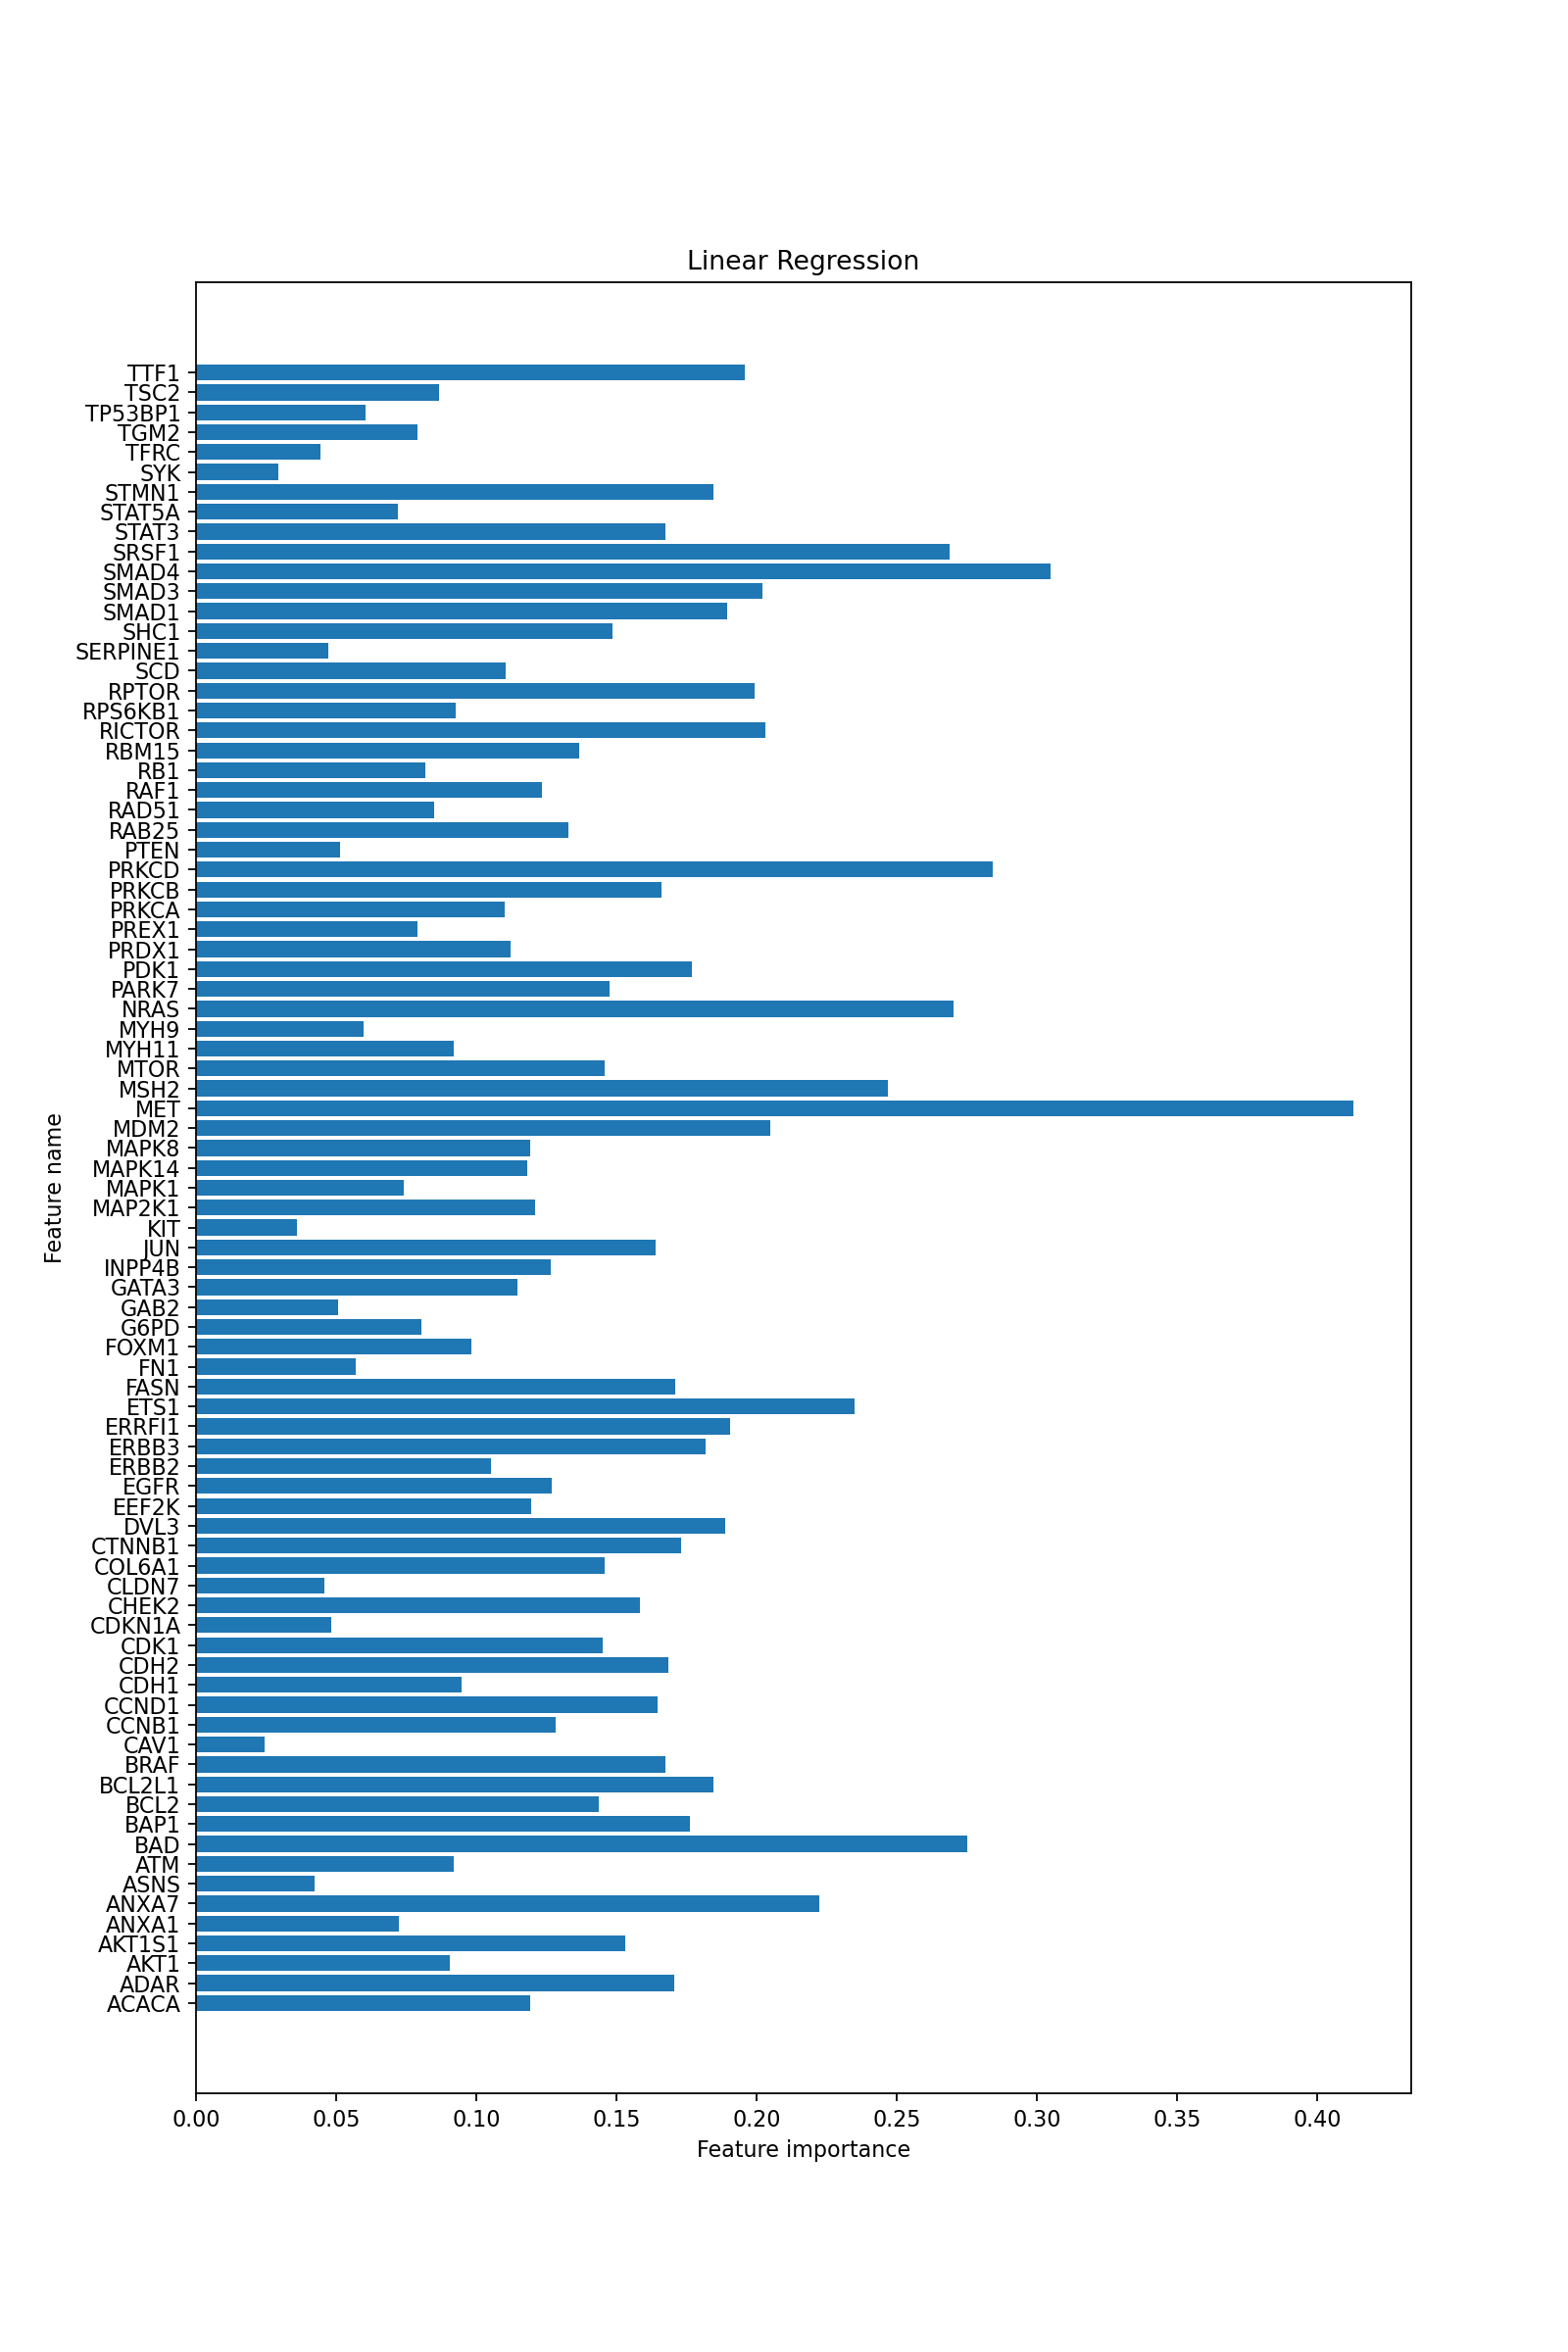

In [40]:
plt.figure(figsize=(10, 15), dpi=80)
df = pd.DataFrame(importance, columns=genes_with_linear_reg_as_best_classifier)
plt.barh(genes_with_linear_reg_as_best_classifier,df.iloc[0,:])
plt.title("Linear Regression")
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.show()

In [41]:
features_for_rf = cancer_features.loc[:, genes_with_random_forest_as_best_classifier]
target_for_rf = cancer_target.loc[:, genes_with_random_forest_as_best_classifier]

# Training complete samples on Random Forest
randomforest_pipeline.fit(features_for_rf, target_for_rf)

# Feature Importance
feature_importance = randomforest_pipeline.named_steps['randforestreg'].feature_importances_
importance = -np.sort(-feature_importance, axis=0)

<IPython.core.display.Javascript object>


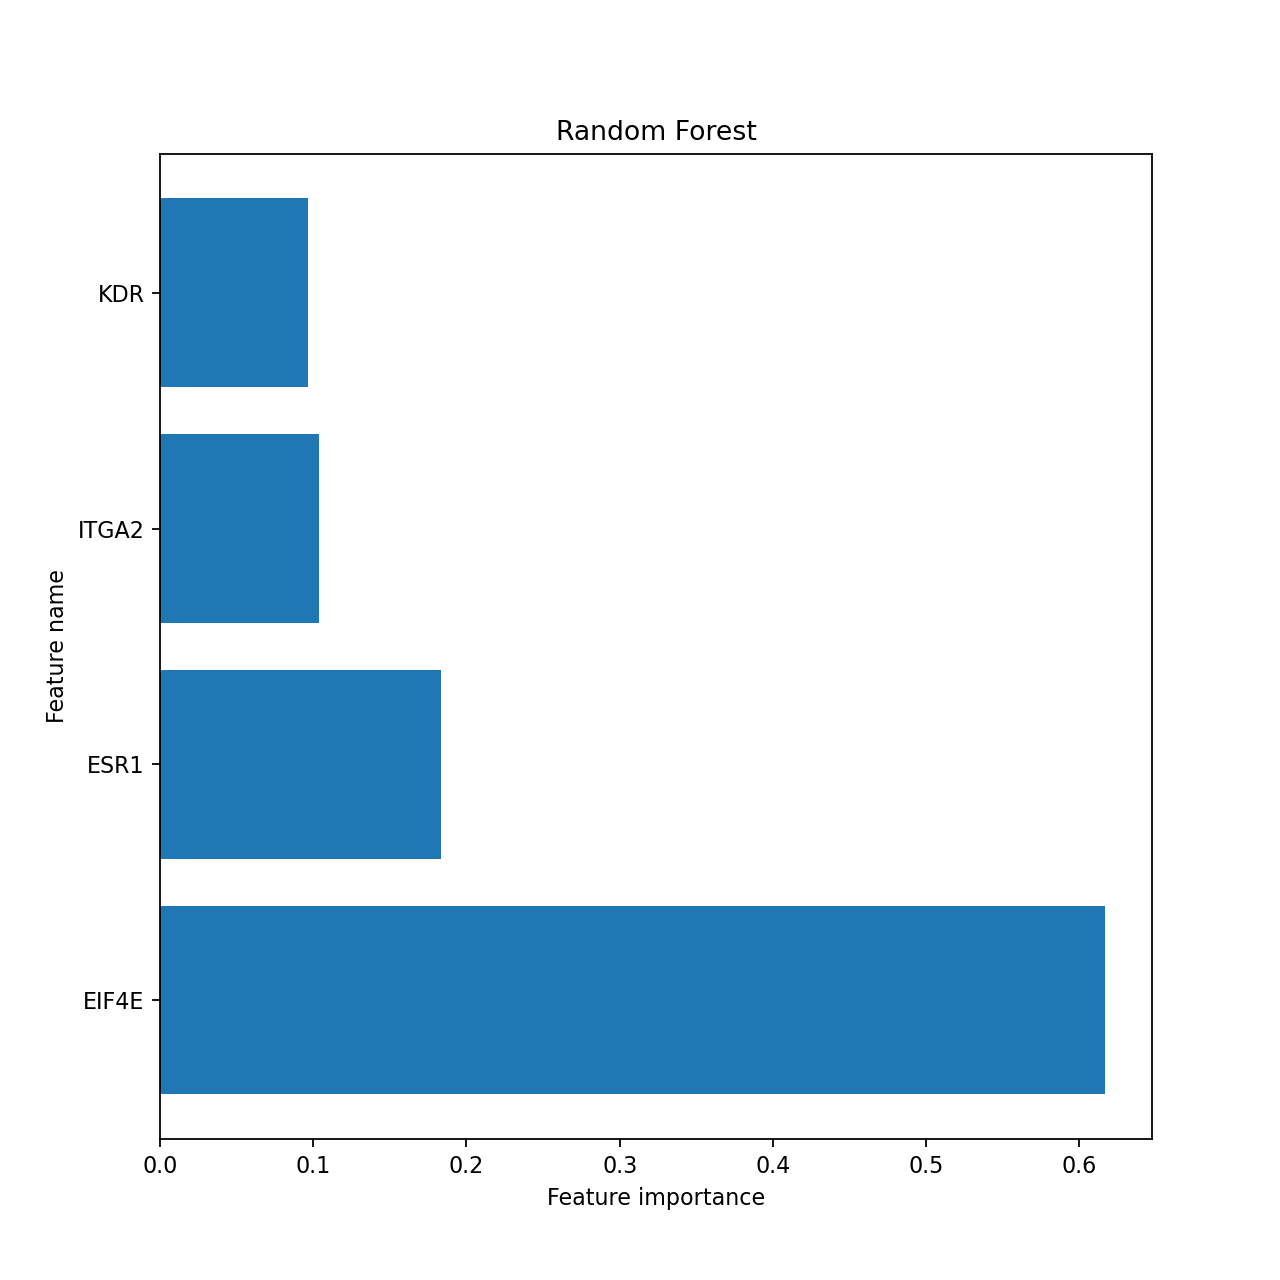

In [42]:
plt.figure(figsize=(8,8), dpi=80)

plt.barh(genes_with_random_forest_as_best_classifier,importance)
plt.title("Random Forest")
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.show()

In [43]:
features_for_brf = cancer_features.loc[:, genes_with_bagging_random_forest_as_best_classifier]
target_for_brf = cancer_target.loc[:, genes_with_bagging_random_forest_as_best_classifier]

# Training complete samples on bagging random forest
bagg_pipeline.fit(features_for_brf, target_for_brf)

# Get Feature Importance
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagg_pipeline.named_steps['baggreg'].estimators_
], axis=0)

<IPython.core.display.Javascript object>


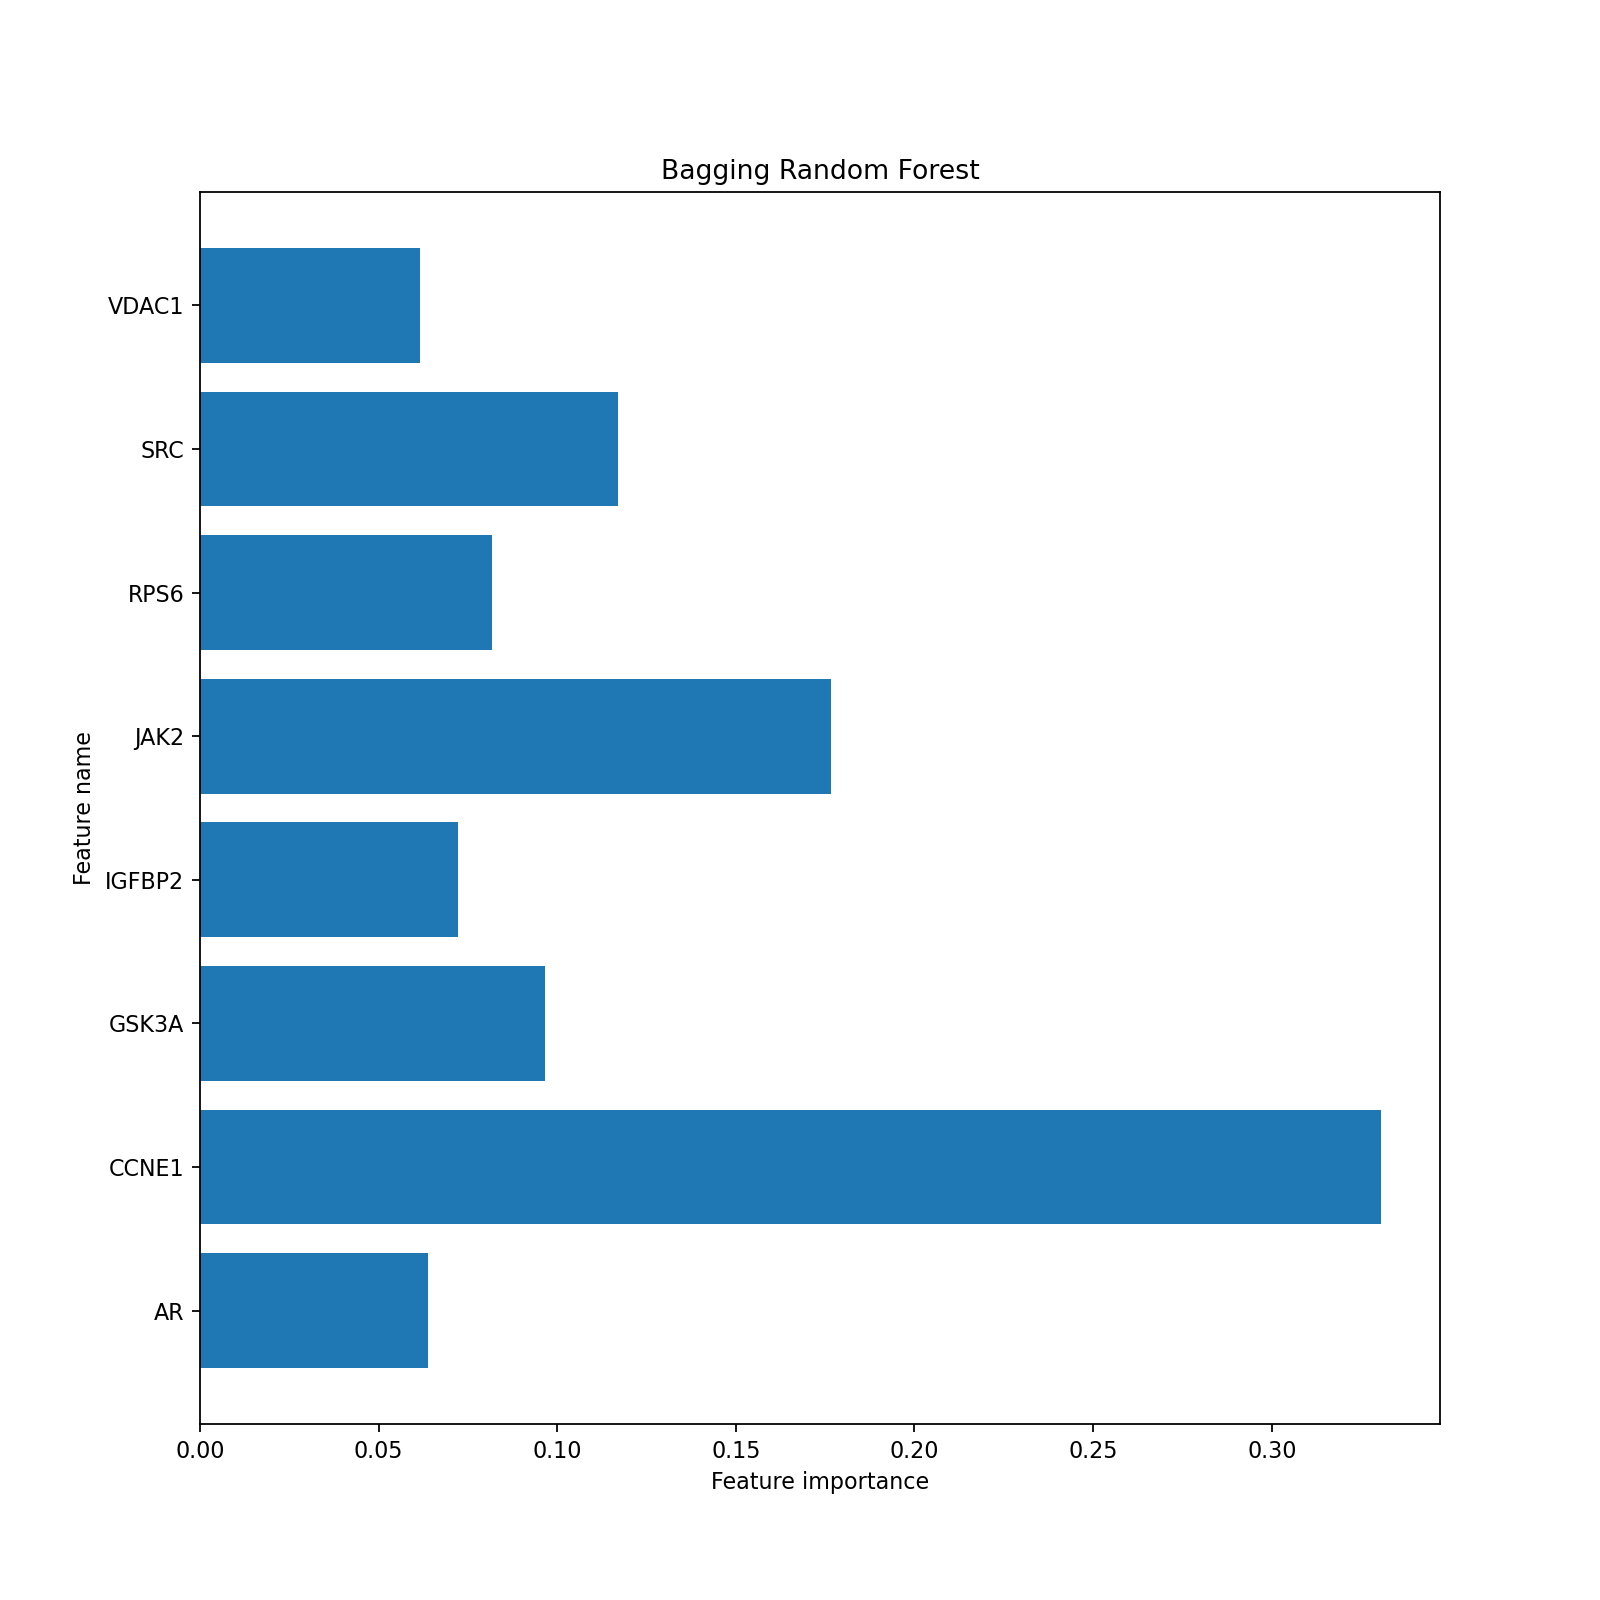

In [44]:
plt.figure(figsize=(10, 10), dpi=80)

plt.barh(genes_with_bagging_random_forest_as_best_classifier,feature_importances)
plt.title("Bagging Random Forest")
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.show()